# Explainable AI neural network classification example
## Author: Oliver Beyer

In [67]:
%pip install lime
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Load Iris data set

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

iris_df = sns.load_dataset("iris")
iris_df.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [69]:
iris_df['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [70]:
iris_df.describe()

sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

In [71]:
iris_df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

## Pairplots of features

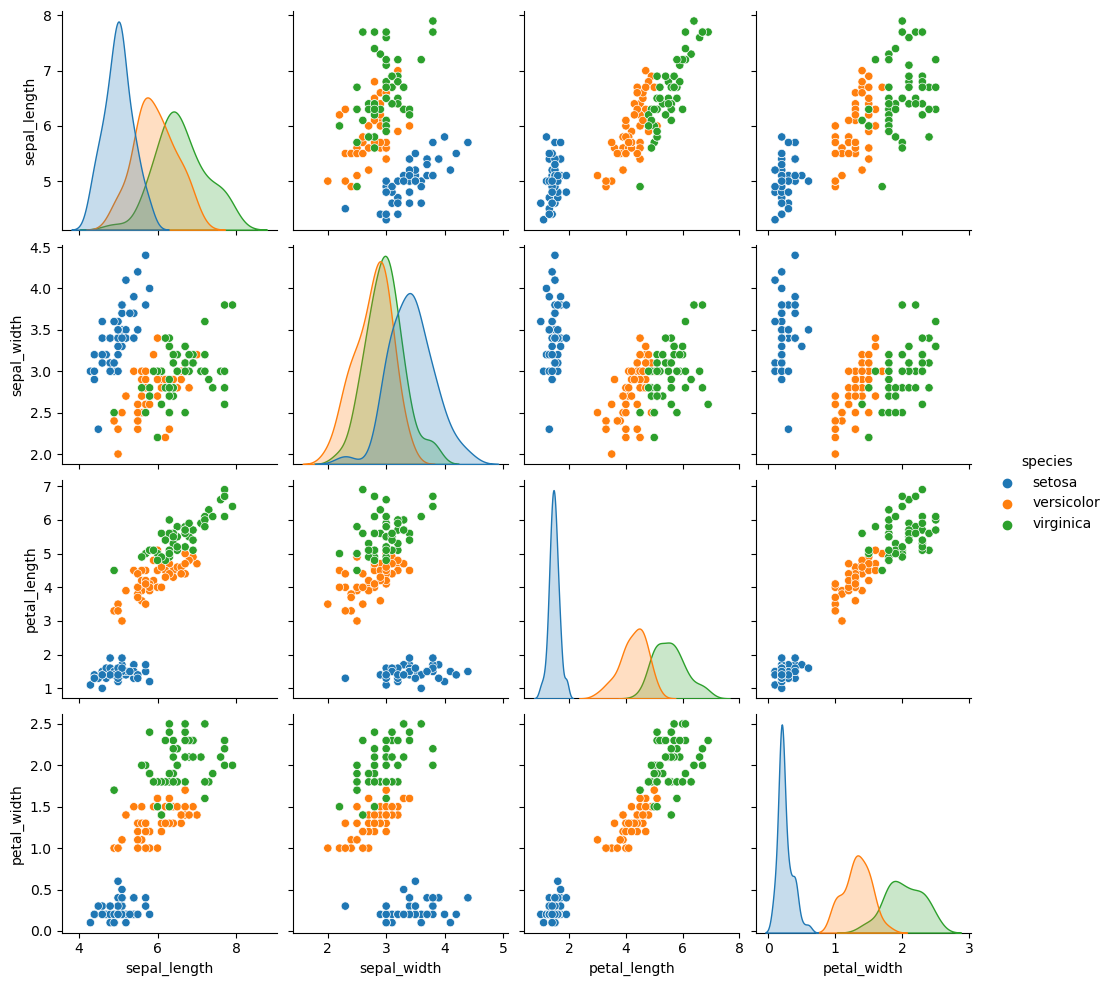

In [72]:
sns.pairplot(iris_df, hue='species')
plt.show()

## Prepare data

In [73]:
X = iris_df.drop(['species'], axis=1)
y = iris_df['species']

## Neural Network approach

Normalizing input and one hot encoding due to neural network

In [74]:
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Scale data
scale = StandardScaler()
X_norm = scale.fit_transform(X)

# Encode classes as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# One hot encode integer labels
one_hot_y = np_utils.to_categorical(encoded_y)

Simple train-test slit

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, one_hot_y, test_size=0.2, random_state=42
)

## Set up classification model

In [76]:
from keras.models import Sequential
from keras.layers import Dense

# Create model
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=4))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 5)                 25        
                                                                 
 dense_5 (Dense)             (None, 3)                 18        
                                                                 
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [77]:
num_epochs = 100

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=num_epochs,
    batch_size=5
)

Epoch 1/100
24/24 [==============================] - 0s 5ms/step - loss: 1.2605 - accuracy: 0.4917 - val_loss: 1.3954 - val_accuracy: 0.4667
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 1.1807 - accuracy: 0.5000 - val_loss: 1.3084 - val_accuracy: 0.4667
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 1.1143 - accuracy: 0.5083 - val_loss: 1.2344 - val_accuracy: 0.4667
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 1.0570 - accuracy: 0.5083 - val_loss: 1.1669 - val_accuracy: 0.4667
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 1.0055 - accuracy: 0.5000 - val_loss: 1.1049 - val_accuracy: 0.4333
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9590 - accuracy: 0.5250 - val_loss: 1.0465 - val_accuracy: 0.4333
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9146 - accuracy: 0.5417 - val_loss: 0.9943 - val_accuracy: 0.4333
Epoch 8/100
2

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


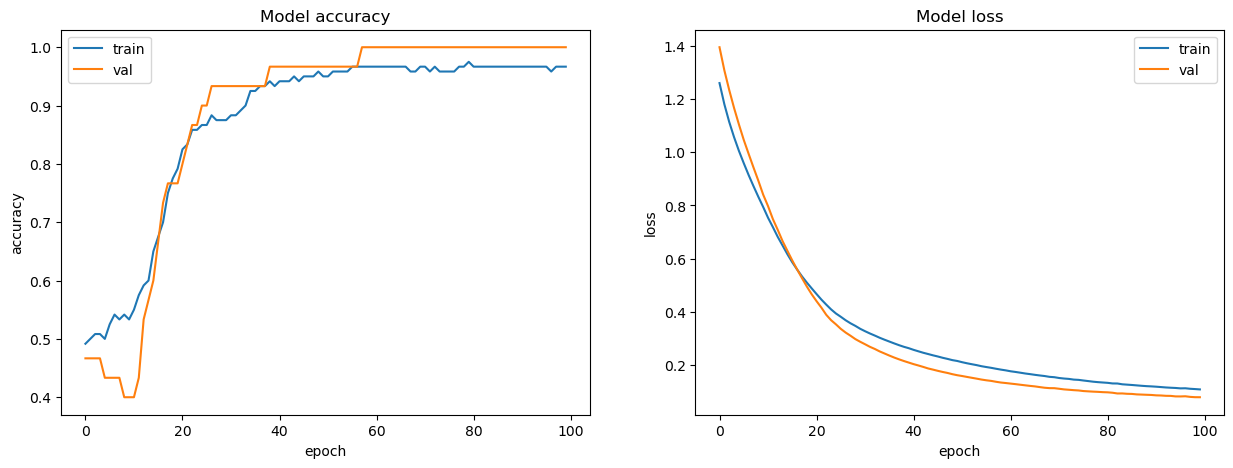

In [78]:
plt.subplots(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

## Plot confusion matrix for predictions on test

1/1 [==============================] - 0s 33ms/step


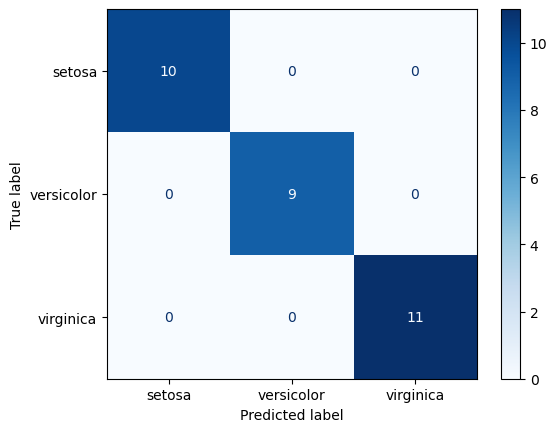

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

pred = model.predict(X_test)

# reverse one hot encoding
df_y_test_one_hot = pd.DataFrame(data=y_test, columns=[0, 1, 2])
np_y_test = df_y_test_one_hot.idxmax(1).to_numpy()
df_pred_one_hot = pd.DataFrame(data=pred, columns=[0, 1, 2])
np_pred = df_pred_one_hot.idxmax(1).to_numpy()

cr = classification_report(np_y_test, np_pred)
cm = confusion_matrix(np_y_test, np_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris_df['species'].unique())

print(cr)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Explain predictions with LIME

In [80]:
from lime import lime_tabular

explainer_lime = lime_tabular.LimeTabularExplainer(X_norm,
                                                        feature_names=X.columns.to_numpy(),
                                                        class_names=y.unique(),
                                                        verbose=True, mode='classification')

# Explain instance for 'setosa'
exp_lime = explainer_lime.explain_instance(X_test[0], model.predict, labels=(0,))
exp_lime.show_in_notebook()

157/157 [==============================] - 0s 800us/step
Intercept 0.3673813175634302
Prediction_local [-0.00496744]
Right: 0.0077992817


In [81]:
# Explain instance for 'versicolor'
exp_lime = explainer_lime.explain_instance(X_test[0], model.predict, labels=(1,))
exp_lime.show_in_notebook()

157/157 [==============================] - 0s 702us/step
Intercept 0.3529485467714486
Prediction_local [0.81823558]
Right: 0.91539466


In [82]:
# Explain instance for label 'virginica'
exp_lime = explainer_lime.explain_instance(X_test[0], model.predict, labels=(2,))
exp_lime.show_in_notebook()

157/157 [==============================] - 0s 1ms/step
Intercept 0.2678965360932845
Prediction_local [0.20980357]
Right: 0.07680606


## Explain feature importance with SHAP

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/150 [00:00<?, ?it/s]

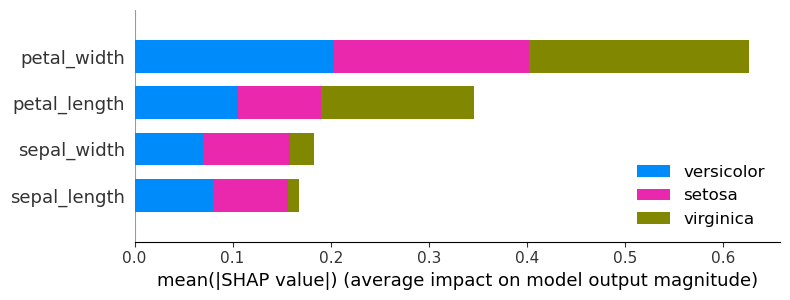

In [83]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.KernelExplainer(model, X_norm)
shap_values = explainer.shap_values(X_norm, nsamples=100)

# Overall impact
shap.summary_plot(shap_values, feature_names=X.columns.to_numpy(), class_names=y.unique())

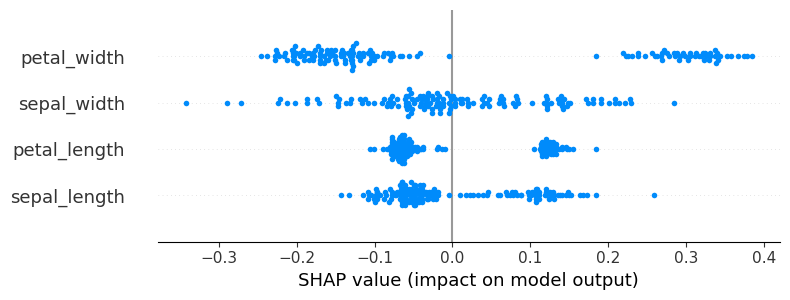

In [84]:
# Impact for 'setosa'
shap.summary_plot(shap_values[0], feature_names=X.columns.to_numpy())

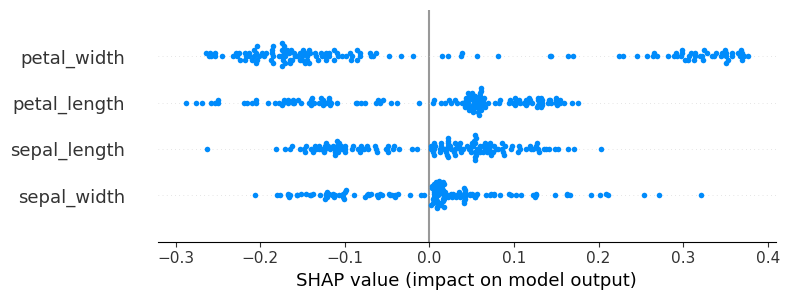

In [85]:
# Impact for 'versicolor'
shap.summary_plot(shap_values[1], feature_names=X.columns.to_numpy())

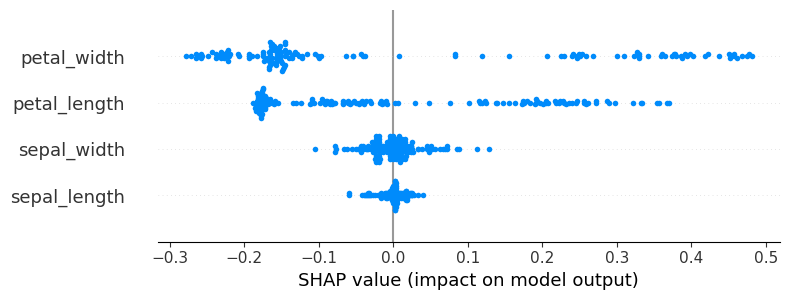

In [86]:
# Impact for 'virginica'
shap.summary_plot(shap_values[2], feature_names=X.columns.to_numpy())